## Space Debris Detection using PySpark, Faster R-CNN (ResNet50) (Reading from HDFS & Skipping Trained Epochs)

This notebook trains a pre-trained Faster R-CNN model (ResNet-50 backbone) to detect space debris in images.
**Key Features:**
* **PySpark for Preprocessing:** Annotation data (CSVs) is loaded and preprocessed using PySpark from HDFS.
* **PyTorch for Training:** A Faster R-CNN model (ResNet-50) is trained using PyTorch, leveraging GPU if available.
* **HDFS Data Source:** Images are read directly from HDFS using the `hdfs` library within the PyTorch Dataset.
* **Checkpointing:** Checks for existing model checkpoints locally (saving only `model.state_dict()`) and skips training for epochs that have already been saved. Loads older dictionary-based checkpoints correctly.
* **Corrected Coordinates:** Handles CSV coordinate format `[xmin, xmax, ymin, ymax]` and converts to model format `[xmin, ymin, xmax, ymax]`.

**Prerequisites:**
* `pyspark` installed (`pip install pyspark`).
* `hdfs` library installed (`pip install hdfs`).
* WebHDFS enabled in your Hadoop `hdfs-site.xml` configuration and HDFS restarted.
* Know your WebHDFS URL (e.g., `http://localhost:9870`) and HDFS username.
* **(Optional)** Previously trained model checkpoints saved locally in the directory specified (`model_save_dir`).

**Project Steps:**
1.  **Setup:** Import libraries, check environment, import HDFS client library.
2.  **PySpark Session & Configuration:** Initialize SparkSession and configure HDFS paths, WebHDFS URL, HDFS user, local model directory, training parameters, and device.
3.  **PySpark Data Loading & Preprocessing:** 
    * Read annotation CSVs (train & validation) from HDFS into Spark DataFrames.
    * Define and apply a User Defined Function (UDF) to parse bounding box strings with correct coordinate mapping.
4.  **Data Preparation for PyTorch:** Convert processed Spark DataFrames into a format suitable for the PyTorch Dataset (e.g., list of dictionaries or Pandas DataFrame).
5.  **PyTorch Custom Dataset:** Define a PyTorch Dataset to load images from HDFS (using paths from Spark) and apply transformations.
6.  **Transforms:** Define image transformations for training and validation.
7.  **Model Definition:** Load and adapt the Faster R-CNN model architecture (ResNet-50 backbone).
8.  **Dataloaders & HDFS Client:** Create PyTorch DataLoaders and initialize the HDFS client for image loading.
9.  **Training:** Train the model on GPU, skipping epochs if a checkpoint file already exists locally, saving new checkpoints locally.
10. **Visualization:** Plot the training loss.
11. **Evaluation:** Load the latest model and evaluate it on the validation set.
12. **Inference:** Demonstrate inference on a single image from HDFS.

### Cell 1: Imports and Environment Check

In [1]:
# Cell 1: Imports
import torch
import torchvision
from torchvision import transforms as T # Using v1 transforms
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import Dataset, DataLoader

import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import os
import sys # Added sys module
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import time
import traceback
import io # Needed for reading from HDFS stream

# --- PySpark Imports ---
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, split, size, expr, when
from pyspark.sql.types import ArrayType, StructType, StructField, FloatType, StringType, IntegerType

# --- HDFS Import (WebHDFS Client for PyTorch Dataset) ---
from hdfs import InsecureClient # Use InsecureClient if no Kerberos
import requests # For HDFS client connection error handling

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"PySpark Version: {pyspark.__version__}")

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.5.1
Torchvision Version: 0.20.1
PySpark Version: 3.5.5
CUDA Available: True
CUDA Version: 11.8
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


### Cell 2: PySpark Session Initialization & Configuration
Configure HDFS paths, WebHDFS connection details, local model directory, and training hyperparameters.

In [2]:
# Cell 2: PySpark Session & Configuration

# --- Set PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON to current environment's Python ---
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
print(f"PYSPARK_PYTHON set to: {sys.executable}")
print(f"PYSPARK_DRIVER_PYTHON set to: {sys.executable}")

# --- Initialize Spark Session ---
try:
    if 'spark' in globals() and spark is not None:
        print("Stopping existing Spark session...")
        spark.stop()
        print("Spark session stopped.")
except NameError:
    print("No existing Spark session named 'spark' to stop.")
except Exception as e:
    print(f"Error stopping existing Spark session: {e}")

print("Initializing new Spark session...")
spark = SparkSession.builder \
    .appName("SpaceDebrisPreprocessing") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.python.worker.timeout", "600s") \
    .getOrCreate()

sc = spark.sparkContext
print(f"Spark Session Initialized. Spark version: {spark.version}")

# --- HDFS Base Path (for PySpark and PyTorch) ---
base_hdfs_path = "/user/dhanu/debris-detection" 

# --- WebHDFS Connection Details (for PyTorch HDFS client) ---
webhdfs_url = "http://localhost:9870" 
hdfs_user = "dhanu" 

train_dir_hdfs = f"{base_hdfs_path}/train"
val_dir_hdfs = f"{base_hdfs_path}/val"
test_dir_hdfs = f"{base_hdfs_path}/test"

train_csv_hdfs_path = f"hdfs://localhost:9000{base_hdfs_path}/train.csv" 
val_csv_hdfs_path = f"hdfs://localhost:9000{base_hdfs_path}/val.csv"     

# --- LOCAL Path for SAVING/LOADING PyTorch models ---
model_save_dir = r"C:\college\CV\COSMOS\debris_models"
os.makedirs(model_save_dir, exist_ok=True)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2 
NUM_EPOCHS = 15
BATCH_SIZE = 2 
LEARNING_RATE = 0.0005 
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
PYTORCH_NUM_WORKERS = 0 
GRAD_CLIP_NORM = 1.0

print(f"--- Configuration ---")
print(f"Using PyTorch device: {DEVICE}")
print(f"WebHDFS URL (for PyTorch image loading): {webhdfs_url}")
print(f"HDFS User (for WebHDFS): {hdfs_user}")
print(f"Base HDFS path: {base_hdfs_path}")
print(f"Train CSV HDFS path (for Spark): {train_csv_hdfs_path}")
print(f"Val CSV HDFS path (for Spark): {val_csv_hdfs_path}")
print(f"Model Save Path (Local): {model_save_dir}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"---------------------")

PYSPARK_PYTHON set to: c:\Users\dhanu\.conda\envs\Bazinga\python.exe
PYSPARK_DRIVER_PYTHON set to: c:\Users\dhanu\.conda\envs\Bazinga\python.exe
Initializing new Spark session...
Spark Session Initialized. Spark version: 3.5.5
--- Configuration ---
Using PyTorch device: cuda
WebHDFS URL (for PyTorch image loading): http://localhost:9870
HDFS User (for WebHDFS): dhanu
Base HDFS path: /user/dhanu/debris-detection
Train CSV HDFS path (for Spark): hdfs://localhost:9000/user/dhanu/debris-detection/train.csv
Val CSV HDFS path (for Spark): hdfs://localhost:9000/user/dhanu/debris-detection/val.csv
Model Save Path (Local): C:\college\CV\COSMOS\debris_models
Epochs: 15
Batch Size: 2
Learning Rate: 0.0005
---------------------


### Cell 3: PySpark Data Loading and Preprocessing
Load annotation CSVs from HDFS, parse bounding boxes, and prepare data for PyTorch.

In [3]:
# Cell 3: PySpark Data Loading and Preprocessing

# Define schema for a single bounding box (xmin, ymin, xmax, ymax for model)
bbox_struct = StructType([
    StructField("xmin", FloatType(), True),
    StructField("ymin", FloatType(), True),
    StructField("xmax", FloatType(), True),
    StructField("ymax", FloatType(), True)
])

# Define schema for a list of bounding boxes
bboxes_list_schema = ArrayType(bbox_struct)

# UDF to parse bounding box strings
@udf(returnType=bboxes_list_schema)
def parse_bboxes_udf(bbox_str):
    if bbox_str is None or not str(bbox_str).strip():
        return []
    try:
        s_bbox_str = str(bbox_str)
        if not (s_bbox_str.startswith('[') and s_bbox_str.endswith(']')):
            return []
        raw_boxes_list = ast.literal_eval(s_bbox_str)
        parsed_boxes = []
        if isinstance(raw_boxes_list, list):
            for box_coords in raw_boxes_list:
                if isinstance(box_coords, (list, tuple)) and len(box_coords) == 4:
                    try:
                        # Original format in CSV: [xmin_val, xmax_val, ymin_val, ymax_val]
                        # Positional unpacking: val1=xmin, val2=xmax, val3=ymin, val4=ymax
                        val1, val2, val3, val4 = map(float, box_coords)
                        
                        # Convert to model format dict {xmin, ymin, xmax, ymax}
                        # Ensure valid box dimensions: xmax > xmin (val2 > val1) and ymax > ymin (val4 > val3)
                        if val2 > val1 and val4 > val3:
                            parsed_boxes.append({
                                "xmin": float(val1), # xmin is the 1st value
                                "ymin": float(val3), # ymin is the 3rd value
                                "xmax": float(val2), # xmax is the 2nd value
                                "ymax": float(val4)  # ymax is the 4th value
                            })
                    except ValueError:
                        # Skip this box if coordinates are not valid floats
                        continue 
        return parsed_boxes
    except (ValueError, SyntaxError, TypeError):
        # Handle errors during literal_eval or other parsing issues
        return []
    except Exception:
        # Catch any other unexpected error
        return []

def preprocess_annotations_spark(csv_path, image_dir_hdfs_base):
    """Loads CSV from HDFS, parses bboxes, and adds full image paths."""
    try:
        df = spark.read.csv(csv_path, header=True, inferSchema=False, emptyValue='') 
        actual_cols = df.columns
        image_id_col_name = None
        bboxes_col_name = None

        # Check for expected column names based on user input ('bboxes0') and common patterns
        if 'ImageId' in actual_cols and 'bboxes0' in actual_cols:
            image_id_col_name = 'ImageId'
            bboxes_col_name = 'bboxes0'
            print(f"Using 'ImageId' and 'bboxes0' columns from {csv_path}")
        elif 'ImageID' in actual_cols and 'bboxes0' in actual_cols:
            image_id_col_name = 'ImageID'
            bboxes_col_name = 'bboxes0'
            print(f"Using 'ImageID' and 'bboxes0' columns from {csv_path}")
        elif 'ImageId' in actual_cols and 'bboxes' in actual_cols:
            image_id_col_name = 'ImageId'
            bboxes_col_name = 'bboxes'
            print(f"Using 'ImageId' and 'bboxes' columns from {csv_path}")
        elif 'ImageID' in actual_cols and 'bboxes' in actual_cols: 
            image_id_col_name = 'ImageID'
            bboxes_col_name = 'bboxes'
            print(f"Using 'ImageID' and 'bboxes' columns from {csv_path}")
        elif 'ImageID' in actual_cols and 'Labels' in actual_cols:
            image_id_col_name = 'ImageID'
            bboxes_col_name = 'Labels'
            print(f"Using 'ImageID' and 'Labels' columns from {csv_path}")
        else:
            if len(actual_cols) >= 2:
                image_id_col_name = actual_cols[0]
                bboxes_col_name = actual_cols[1]
                print(f"Warning: Using first two columns '{image_id_col_name}' and '{bboxes_col_name}' from {csv_path} as standard names were not found.")
            else:
                raise ValueError(f"CSV {csv_path} must have at least two columns for ImageId and bounding boxes. Found columns: {actual_cols}")

        df = df.withColumnRenamed(image_id_col_name, "ImageId_orig") \
                 .withColumnRenamed(bboxes_col_name, "bbox_str_orig")
        
        df = df.withColumn("ImageId", col("ImageId_orig").cast(StringType())) \
                 .withColumn("bbox_str", col("bbox_str_orig").cast(StringType()))
        
        df_processed = df.withColumn("bboxes_parsed", parse_bboxes_udf(col("bbox_str")))
        df_processed = df_processed.withColumn("image_path_hdfs", 
                                             expr(f"concat('{image_dir_hdfs_base}/', ImageId, '.jpg')"))
        
        df_final = df_processed.select("ImageId", "image_path_hdfs", "bboxes_parsed") \
                               .withColumnRenamed("bboxes_parsed", "bboxes")
        
        return df_final
    except Exception as e:
        print(f"Error preprocessing CSV {csv_path} with Spark: {e}")
        traceback.print_exc()
        return None

print("Preprocessing training annotations with PySpark...")
train_df_spark = preprocess_annotations_spark(train_csv_hdfs_path, train_dir_hdfs)
if train_df_spark:
    train_df_spark.show(5, truncate=False)
    print(f"Training DataFrame schema:")
    train_df_spark.printSchema()
    train_samples_spark = train_df_spark.count()
    print(f"Found {train_samples_spark} training samples after Spark processing.")

print("\nPreprocessing validation annotations with PySpark...")
val_df_spark = preprocess_annotations_spark(val_csv_hdfs_path, val_dir_hdfs)
if val_df_spark:
    val_df_spark.show(5, truncate=False)
    print(f"Validation DataFrame schema:")
    val_df_spark.printSchema()
    val_samples_spark = val_df_spark.count()
    print(f"Found {val_samples_spark} validation samples after Spark processing.")


Preprocessing training annotations with PySpark...
Using 'ImageID' and 'bboxes' columns from hdfs://localhost:9000/user/dhanu/debris-detection/train.csv
+-------+----------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ImageId|image_path_hdfs                         |bboxes                                                                                                                                                                           |
+-------+----------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0      |/user/dhanu/debris-detection/train/0.jpg|[{282.0, 58.0, 308.0, 86.0}, {228.0, 191.0, 256.0, 218.0}, {101.0, 203.0, 133.0, 225.0}, {81.0, 466.0, 112.0, 

### Cell 4: Data Preparation for PyTorch
Convert Spark DataFrames to Pandas DataFrames or list of dicts for the PyTorch Dataset.

In [4]:
# Cell 4: Data Preparation for PyTorch
train_data_pytorch = []
val_data_pytorch = []

if train_df_spark:
    print("\nCollecting training data for PyTorch...")
    train_data_list = train_df_spark.collect() 
    train_data_pytorch = [
        {"ImageId": row.ImageId, "image_path_hdfs": row.image_path_hdfs, "bboxes": [bbox.asDict() for bbox in row.bboxes] if row.bboxes else []} # Use asDict() for Row to dict conversion
        for row in train_data_list
        if row.ImageId is not None and row.image_path_hdfs is not None 
    ]
    print(f"Collected {len(train_data_pytorch)} training records for PyTorch.")
    if train_data_pytorch:
        print("Sample PyTorch training record:", train_data_pytorch[0])
else:
    print("Skipping PyTorch training data preparation due to Spark errors or no data.")

if val_df_spark:
    print("\nCollecting validation data for PyTorch...")
    val_data_list = val_df_spark.collect()
    val_data_pytorch = [
        {"ImageId": row.ImageId, "image_path_hdfs": row.image_path_hdfs, "bboxes": [bbox.asDict() for bbox in row.bboxes] if row.bboxes else []} # Use asDict() for Row to dict conversion
        for row in val_data_list
        if row.ImageId is not None and row.image_path_hdfs is not None 
    ]
    print(f"Collected {len(val_data_pytorch)} validation records for PyTorch.")
    if val_data_pytorch:
        print("Sample PyTorch validation record:", val_data_pytorch[0])
else:
    print("Skipping PyTorch validation data preparation due to Spark errors or no data.")


Collected 20000 training records for PyTorch.
Sample PyTorch training record: {'ImageId': '0', 'image_path_hdfs': '/user/dhanu/debris-detection/train/0.jpg', 'bboxes': [{'xmin': 282.0, 'ymin': 58.0, 'xmax': 308.0, 'ymax': 86.0}, {'xmin': 228.0, 'ymin': 191.0, 'xmax': 256.0, 'ymax': 218.0}, {'xmin': 101.0, 'ymin': 203.0, 'xmax': 133.0, 'ymax': 225.0}, {'xmin': 81.0, 'ymin': 466.0, 'xmax': 112.0, 'ymax': 494.0}, {'xmin': 442.0, 'ymin': 277.0, 'xmax': 474.0, 'ymax': 305.0}]}

Collected 2000 validation records for PyTorch.
Sample PyTorch validation record: {'ImageId': '0', 'image_path_hdfs': '/user/dhanu/debris-detection/val/0.jpg', 'bboxes': [{'xmin': 428.0, 'ymin': 381.0, 'xmax': 457.0, 'ymax': 410.0}, {'xmin': 100.0, 'ymin': 234.0, 'xmax': 130.0, 'ymax': 256.0}, {'xmin': 115.0, 'ymin': 261.0, 'xmax': 147.0, 'ymax': 284.0}]}


### Cell 5: Custom PyTorch Dataset Class (`SpaceDebrisDatasetPyTorch`)
This dataset takes the preprocessed list of dictionaries (from Spark), an HDFS client, and image directory to load images from HDFS and apply transforms.

In [5]:
# Cell 5: Custom PyTorch Dataset Class
class SpaceDebrisDatasetPyTorch(Dataset):
    def __init__(self, data_records, hdfs_client, transforms=None):
        self.data_records = data_records
        self.hdfs_client = hdfs_client
        self.transforms = transforms

    def __len__(self):
        return len(self.data_records)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        record = self.data_records[idx]
        img_path_hdfs = record['image_path_hdfs']
        img_id = record.get('ImageId', f'index_{idx}') 

        if not img_path_hdfs or not self.hdfs_client:
            # print(f"Skipping sample for img_id {img_id}: Missing HDFS path or HDFS client.") # Reduce verbosity
            return None

        try:
            with self.hdfs_client.read(img_path_hdfs) as reader: 
                img_bytes = reader.read() 
            if not img_bytes:
                print(f"Warning: Image {img_id} from HDFS path {img_path_hdfs} is empty. Returning None.")
                return None
            image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image file not found on HDFS for {img_id} at path {img_path_hdfs}. Returning None.")
            return None
        except Exception as e:
            print(f"Error loading/reading image {img_id} from HDFS path {img_path_hdfs}: {e}")
            # traceback.print_exc() # Uncomment for detailed error
            return None 

        boxes_data = record.get('bboxes', [])
        boxes = []
        for box_info in boxes_data:
            if not isinstance(box_info, dict) or not all(k in box_info for k in ['xmin', 'ymin', 'xmax', 'ymax']):
                continue
            x_min, y_min, x_max, y_max = box_info['xmin'], box_info['ymin'], box_info['xmax'], box_info['ymax']
            if x_max > x_min and y_max > y_min: 
                boxes.append([float(x_min), float(y_min), float(x_max), float(y_max)]) 
        
        num_objs = len(boxes)
        target = {}

        if num_objs > 0:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.ones((num_objs,), dtype=torch.int64) 
            target["image_id"] = torch.tensor([idx])
            area = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
            target["area"] = area
            target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
            if torch.any(target['area'] <= 0):
                 print(f"Warning: Zero or negative area detected in boxes for image {img_id} (idx {idx}). Boxes: {target['boxes']}. Returning None.")
                 return None
        else: 
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros(0, dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])
            target["area"] = torch.zeros(0, dtype=torch.float32)
            target["iscrowd"] = torch.zeros(0, dtype=torch.int64)

        image_tensor = None
        if self.transforms:
            try:
                image_tensor = self.transforms(image)
            except Exception as e:
                print(f"Error applying transforms to image {img_id}: {e}")
                return None
        else:
            image_tensor = T.ToTensor()(image) 

        if not isinstance(image_tensor, torch.Tensor):
            print(f"Warning: Image for index {idx} ({img_id}) is not a Tensor after transforms (type: {type(image_tensor)}). Returning None.")
            return None
            
        return image_tensor, target

### Cell 6: Transforms (`get_transform`)

In [6]:
# Cell 6: Transforms (Using v1 API)
def get_transform(train):
    transforms_list = []
    transforms_list.append(T.ToTensor())
    if train:
        transforms_list.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms_list)

### Cell 7: Model Definition (`get_object_detection_model`)
Using ResNet-50 FPN backbone.

In [7]:
# Cell 7: Model Definition
def get_object_detection_model(num_classes):
    # Load a model pre-trained on COCO with ResNet-50 backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    print("Using Faster R-CNN with ResNet-50 FPN backbone.")
    return model

### Cell 8: Collate Function (`collate_fn`)

In [8]:
# Cell 8: Collate Function for DataLoader
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if not batch: 
        return None, None 
    return tuple(zip(*batch))

### Cell 9: Create Datasets, HDFS Client, and DataLoaders for PyTorch

Attempting to connect to WebHDFS at http://localhost:9870 as user 'dhanu' for PyTorch image loading...
Successfully connected WebHDFS client for PyTorch. Base path '/user/dhanu/debris-detection' status check successful.

Creating PyTorch Training Dataset...
Creating PyTorch Validation Dataset...

PyTorch Training samples: 20000
PyTorch Validation samples: 2000

PyTorch DataLoaders created.

Attempting to display a sample from PyTorch training set...


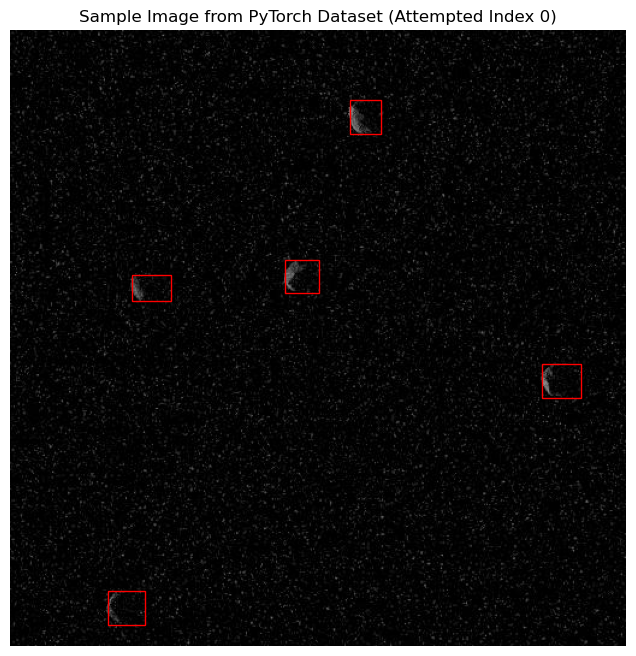

In [9]:
# Cell 9: Create Datasets, HDFS Client, and DataLoaders for PyTorch
hdfs_torch_client = None
train_dataset_pytorch = None
val_dataset_pytorch = None
train_loader = None
val_loader = None

try:
    print(f"Attempting to connect to WebHDFS at {webhdfs_url} as user '{hdfs_user}' for PyTorch image loading...")
    hdfs_torch_client = InsecureClient(webhdfs_url, user=hdfs_user, timeout=10) 
    hdfs_torch_client.status(base_hdfs_path.rstrip('/') + '/', strict=False) 
    print(f"Successfully connected WebHDFS client for PyTorch. Base path '{base_hdfs_path}' status check successful.")
except requests.exceptions.ConnectionError as ce:
    print(f"WebHDFS Connection Error: Failed to connect to {webhdfs_url}. Ensure WebHDFS is running and accessible. Error: {ce}")
    traceback.print_exc()
    hdfs_torch_client = None
except Exception as e:
    print(f"Error connecting or checking status with WebHDFS client for PyTorch: {e}")
    traceback.print_exc()
    hdfs_torch_client = None 

if hdfs_torch_client and train_data_pytorch and val_data_pytorch:
    print("\nCreating PyTorch Training Dataset...")
    train_dataset_pytorch = SpaceDebrisDatasetPyTorch(train_data_pytorch, hdfs_torch_client, get_transform(train=True))
    print("Creating PyTorch Validation Dataset...")
    val_dataset_pytorch = SpaceDebrisDatasetPyTorch(val_data_pytorch, hdfs_torch_client, get_transform(train=False))

    if len(train_dataset_pytorch) > 0 and len(val_dataset_pytorch) > 0:
        print(f"\nPyTorch Training samples: {len(train_dataset_pytorch)}")
        print(f"PyTorch Validation samples: {len(val_dataset_pytorch)}")

        train_loader = DataLoader(
            train_dataset_pytorch,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=PYTORCH_NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=True if DEVICE.type == 'cuda' else False 
        )
        val_loader = DataLoader(
            val_dataset_pytorch,
            batch_size=1, 
            shuffle=False,
            num_workers=PYTORCH_NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=True if DEVICE.type == 'cuda' else False
        )
        print("\nPyTorch DataLoaders created.")
    else:
        print("\nOne or both PyTorch datasets are empty after filtering or due to earlier errors. Cannot create DataLoaders.")
        if not train_data_pytorch: print("Train data for PyTorch is empty.")
        if not val_data_pytorch: print("Validation data for PyTorch is empty.")
elif not hdfs_torch_client:
    print("\nCannot create PyTorch datasets: HDFS client for PyTorch is not available.")
else:
    print("\nCannot create PyTorch datasets: Spark preprocessing did not yield data, or data was empty.")

# Display a sample from the PyTorch training set (if available and valid)
if train_dataset_pytorch and len(train_dataset_pytorch) > 0:
    print("\nAttempting to display a sample from PyTorch training set...")
    sample_displayed = False
    for i in range(min(len(train_dataset_pytorch), 5)): 
        try:
            sample_data = train_dataset_pytorch[i]
            if sample_data is not None:
                img_tensor, target_dict = sample_data
                if img_tensor is not None and target_dict is not None:
                    img_pil = T.ToPILImage()(img_tensor)
                    plt.figure(figsize=(8, 8))
                    ax = plt.gca()
                    ax.imshow(img_pil)
                    if 'boxes' in target_dict and len(target_dict['boxes']) > 0:
                        for box in target_dict['boxes'].cpu().numpy():
                            xmin, ymin, xmax, ymax = box
                            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                                   linewidth=1, edgecolor='r', facecolor='none')
                            ax.add_patch(rect)
                    plt.title(f"Sample Image from PyTorch Dataset (Attempted Index {i})")
                    plt.axis('off')
                    plt.show()
                    sample_displayed = True
                    break 
        except Exception as e:
            print(f"Error displaying sample at index {i} from PyTorch dataset: {e}")
    if not sample_displayed:
        print("Could not display any valid sample from the first few items of the PyTorch training dataset.")
elif train_loader is None: 
     print("\nPyTorch Training dataset is empty or not created, cannot display sample.")


### Cell 10: Training Loop
Handles model training, checkpoint saving/loading (state_dict only), and loss tracking.

In [10]:
# Cell 10: Training Loop (Standard Precision, state_dict saving)
model = get_object_detection_model(NUM_CLASSES)
model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

all_train_losses = [] 
trained_epochs_losses = {} 

if train_loader is None or val_loader is None:
    print("DataLoaders are not initialized. Skipping training loop.")
else:
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        # Checkpoint path using the user-specified directory and naming convention
        model_checkpoint_path = os.path.join(model_save_dir, f'debris_detector_epoch_{epoch+1}.pth')

        if os.path.exists(model_checkpoint_path):
            print(f"Checkpoint for epoch {epoch+1} already exists at {model_checkpoint_path}. Skipping training for this epoch.")
            # Since only state_dict is saved, we can't load 'loss' from checkpoint here.
            # We'll just append None and the plotting logic will handle it.
            all_train_losses.append(None) 
            if lr_scheduler: lr_scheduler.step() 
            continue 

        model.train()
        train_loss_accum = 0.0
        num_train_batches = 0
        
        progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]")
        for batch_idx, (images, targets) in enumerate(progress_bar_train):
            if images is None or targets is None: 
                print(f"Skipping a batch in epoch {epoch+1} (batch index {batch_idx}) due to collation error or empty batch.")
                continue
            
            images = list(img.to(DEVICE) for img in images)
            targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()

                if not np.isfinite(loss_value):
                    print(f"Epoch {epoch+1}, Batch {batch_idx}: Non-finite loss detected: {loss_value}. Skipping batch.")
                    continue

                optimizer.zero_grad()
                losses.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
                optimizer.step()

                train_loss_accum += loss_value
                num_train_batches += 1
                progress_bar_train.set_postfix(loss=f'{loss_value:.4f}')
                
            except RuntimeError as e:
                if "CUDA out of memory" in str(e):
                    print(f"CUDA out of memory during training epoch {epoch+1}, batch {batch_idx}. Try reducing batch size.")
                    torch.cuda.empty_cache()
                    continue 
                else:
                    print(f"Runtime error during training epoch {epoch+1}, batch {batch_idx}: {e}")
                    traceback.print_exc()
                    continue 
            except Exception as e:
                print(f"An unexpected error occurred during training batch {batch_idx} in epoch {epoch+1}: {e}")
                traceback.print_exc()
                continue

        if lr_scheduler:
            lr_scheduler.step()

        avg_train_loss = train_loss_accum / num_train_batches if num_train_batches > 0 else float('nan') 
        all_train_losses.append(avg_train_loss)
        if num_train_batches > 0:
             trained_epochs_losses[epoch + 1] = avg_train_loss
        
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} [Training] - Avg Loss: {avg_train_loss:.4f}, Duration: {epoch_duration:.2f}s, LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save model state_dict only
        try:
            torch.save(model.state_dict(), model_checkpoint_path)
            print(f"Saved model state_dict for epoch {epoch+1} to {model_checkpoint_path}")
        except Exception as e:
            print(f"Error saving model state_dict for epoch {epoch+1}: {e}")
            traceback.print_exc()
        
        # Simple validation pass (not full mAP, just loss)
        model.eval()
        val_loss_accum = 0.0
        num_val_batches = 0
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation]")
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(progress_bar_val):
                if images is None or targets is None:
                    continue
                images = list(img.to(DEVICE) for img in images)
                targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
                
                try:
                    loss_dict = model(images, targets) 
                    losses = sum(loss for loss in loss_dict.values())
                    val_loss_accum += losses.item()
                    num_val_batches +=1
                    progress_bar_val.set_postfix(loss=f'{losses.item():.4f}')
                except Exception as e:
                    print(f"Error during validation batch {batch_idx} in epoch {epoch+1}: {e}")
                    continue
                    
        avg_val_loss = val_loss_accum / num_val_batches if num_val_batches > 0 else float('nan')
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} [Validation] - Avg Loss: {avg_val_loss:.4f}")
        
    print("\nTraining finished.")

# Stop Spark session at the very end of processing
if 'spark' in globals() and spark.getActiveSession():
    print("Stopping Spark session at the end of the notebook.")
    spark.stop()

Using Faster R-CNN with ResNet-50 FPN backbone.
Starting training for 15 epochs...
Checkpoint for epoch 1 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_1.pth. Skipping training for this epoch.
Checkpoint for epoch 2 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_2.pth. Skipping training for this epoch.
Checkpoint for epoch 3 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_3.pth. Skipping training for this epoch.
Checkpoint for epoch 4 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_4.pth. Skipping training for this epoch.
Checkpoint for epoch 5 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_5.pth. Skipping training for this epoch.
Checkpoint for epoch 6 already exists at C:\college\CV\COSMOS\debris_models\debris_detector_epoch_6.pth. Skipping training for this epoch.
Checkpoint for epoch 7 already exists at C:\college\CV\COSMOS\debris_models\debris_

c:\Users\dhanu\.conda\envs\Bazinga\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


### Cell 11: Plot Training Loss
Plot the average training loss for epochs that were actually trained.

In [11]:
# Cell 11: Plot Training Loss
if trained_epochs_losses:
    plot_epochs = []
    plot_losses = []
    for epoch, loss in sorted(trained_epochs_losses.items()):
        if loss is not None and not np.isnan(loss):
            plot_epochs.append(epoch)
            plot_losses.append(loss)
    
    if plot_epochs:
        plt.figure(figsize=(10, 5))
        plt.plot(plot_epochs, plot_losses, marker='o', linestyle='-')
        plt.title('Average Training Loss per Trained Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.xticks(plot_epochs)
        plt.grid(True)
        plt.show()
    else:
        print("No valid loss data from currently trained epochs to plot.")
elif any(l is not None and not np.isnan(l) for l in all_train_losses):
    # This part might be less useful now as skipped epochs will have None for loss
    epochs_with_any_data = [i + 1 for i, l in enumerate(all_train_losses) if l is not None and not np.isnan(l)]
    losses_with_any_data = [l for l in all_train_losses if l is not None and not np.isnan(l)]
    if epochs_with_any_data:
        plt.figure(figsize=(10, 5))
        plt.plot(epochs_with_any_data, losses_with_any_data, marker='o', linestyle='-')
        plt.title('Average Training Loss (Potentially including loaded checkpoints - state_dict only)')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.xticks(epochs_with_any_data)
        plt.grid(True)
        plt.show()
    else:
        print("No valid loss data available from training or (lossless) checkpoints to plot.")
else:
    print("No epochs were trained or loss data is unavailable. Cannot plot training loss.")

No epochs were trained or loss data is unavailable. Cannot plot training loss.


### Cell 12: Evaluation (Simplified)
Load the latest saved model (handling dictionary or state_dict) and perform a simplified evaluation pass (loss on validation set).
A full evaluation would typically involve calculating metrics like mAP (mean Average Precision).

In [14]:
# Cell 12: Evaluation (Simplified, loads state_dict or dictionary)
latest_epoch_for_eval = 0
eval_model_path = None

# Assume model_save_dir, NUM_EPOCHS, val_loader, get_object_detection_model,
# DEVICE, np, os, torch, tqdm are defined/imported earlier in the script.

if os.path.exists(model_save_dir):
    # Find the latest saved checkpoint file based on the naming convention
    for epoch_num in range(NUM_EPOCHS, 0, -1):
        # Checkpoint name pattern matching user request
        path = os.path.join(model_save_dir, f'debris_detector_epoch_{epoch_num}.pth')
        if os.path.exists(path):
            latest_epoch_for_eval = epoch_num
            eval_model_path = path
            break # Found the latest epoch, stop searching

if latest_epoch_for_eval > 0 and eval_model_path and val_loader is not None:
    print(f"\nLoading model checkpoint from epoch {latest_epoch_for_eval} ({eval_model_path}) for evaluation...")

    # Instantiate the model architecture (ResNet50)
    eval_model = get_object_detection_model(NUM_CLASSES)
    try:
        # Load the checkpoint file.
        # weights_only=False allows loading older dictionary-based checkpoints.
        # Use weights_only=True if you are certain only state_dict was saved.
        checkpoint = torch.load(eval_model_path, map_location=DEVICE, weights_only=False)

        # Check if the loaded object is a dictionary (older format) or just the state_dict
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            print("Checkpoint loaded as dictionary. Extracting model_state_dict.")
            eval_model.load_state_dict(checkpoint['model_state_dict'])
            # Try to print the loss if it exists in the dictionary
            saved_loss = checkpoint.get('loss', None)
            if saved_loss is not None:
                # Ensure loss value is a number before formatting
                if isinstance(saved_loss, (int, float)) and not np.isnan(saved_loss):
                     print(f"  Loss recorded in checkpoint: {saved_loss:.4f}")
                else:
                     print(f"  Loss recorded in checkpoint: {saved_loss} (invalid format)")
            else:
                print("  Loss value not found in the checkpoint dictionary.")
        else:
            # Assume it's just the state_dict (newer format)
            print("Checkpoint loaded as state_dict.")
            eval_model.load_state_dict(checkpoint)
            print("  Loss value is not stored in state_dict-only checkpoints.")

        # Move model to the configured device (GPU/CPU)
        eval_model.to(DEVICE)
        # Set model to evaluation mode initially (disables dropout, etc.)
        eval_model.eval()

        total_eval_loss = 0
        eval_batches = 0
        print("Running evaluation on the validation set...")
        # Disable gradient calculations during evaluation
        with torch.no_grad():
            # Iterate through the validation data loader
            for images, targets in tqdm(val_loader, desc="Evaluating"):
                # Skip if batch is invalid (e.g., due to collation errors)
                if images is None or targets is None: continue
                # Move images and targets to the configured device
                images = list(img.to(DEVICE) for img in images)
                targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

                # Temporarily switch to train() mode *only* for loss calculation
                # because in eval() mode, FasterRCNN returns predictions, not loss dict
                eval_model.train()
                loss_dict = eval_model(images, targets)
                eval_model.eval() # Switch back to eval mode immediately

                # Now loss_dict should be a dictionary containing different loss components
                losses = sum(loss for loss in loss_dict.values()) # Sum up all loss components
                total_eval_loss += losses.item() # Accumulate the scalar loss value
                eval_batches += 1 # Increment batch counter

        # Calculate the average validation loss
        avg_eval_loss = total_eval_loss / eval_batches if eval_batches > 0 else float('nan')
        print(f"Average Validation Loss (Epoch {latest_epoch_for_eval} model): {avg_eval_loss:.4f}")
        print("Simplified evaluation (loss only). For mAP, further implementation is needed.")

    except Exception as e:
        # Catch and print any errors during evaluation
        print(f"Error during evaluation with model {eval_model_path}: {e}")
        traceback.print_exc()

elif not val_loader:
    # Handle case where validation loader wasn't created
    print("\nValidation loader not available, skipping evaluation.")
else:
    # Handle case where no model checkpoints were found
    print(f"\nNo saved models found in the directory '{model_save_dir}'. Skipping evaluation.")


Loading model checkpoint from epoch 15 (C:\college\CV\COSMOS\debris_models\debris_detector_epoch_15.pth) for evaluation...
Using Faster R-CNN with ResNet-50 FPN backbone.
Checkpoint loaded as dictionary. Extracting model_state_dict.
  Loss recorded in checkpoint: 0.2801
Running evaluation on the validation set...


Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Average Validation Loss (Epoch 15 model): 0.2197
Simplified evaluation (loss only). For mAP, further implementation is needed.


### Cell 13: Inference on a Single Image
Demonstrate how to use the trained model for inference on a single test image from HDFS.


Loading model checkpoint from epoch 15 for inference from C:\college\CV\COSMOS\debris_models\debris_detector_epoch_15.pth
Using Faster R-CNN with ResNet-50 FPN backbone.
Checkpoint loaded as dictionary. Extracting model_state_dict.
Inference model loaded and set to evaluation mode.
Selected test image from HDFS: /user/dhanu/debris-detection/test/0.jpg

Running inference on: /user/dhanu/debris-detection/test/0.jpg
Found 4 objects with confidence >= 0.5


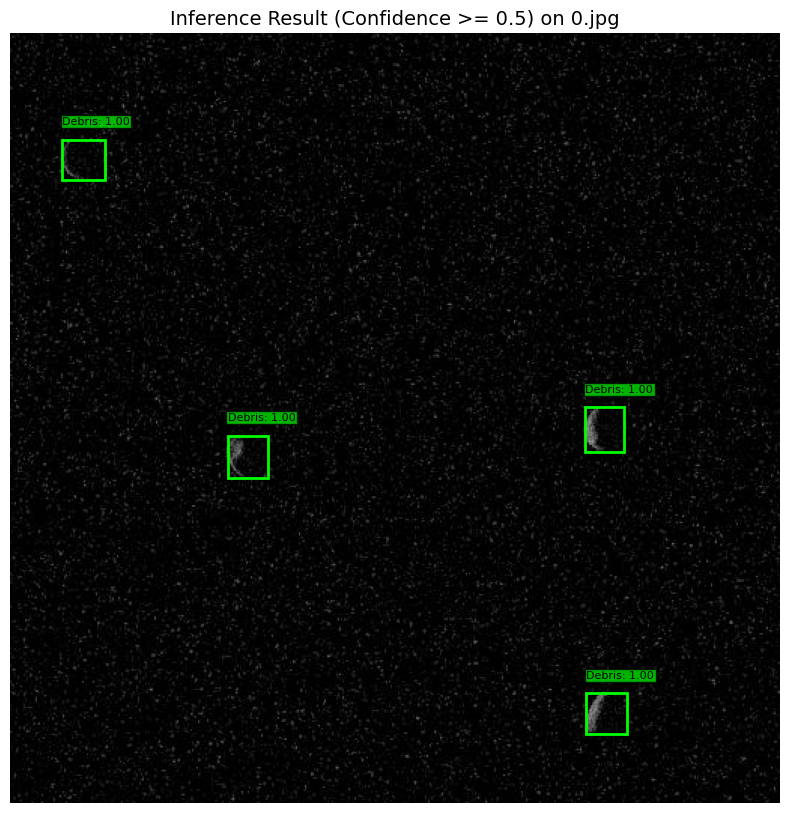

In [13]:
# Cell 13: Inference on a Single Image (loads state_dict or dictionary)
inference_model = None
saved_model_path_for_inference = None
latest_trained_epoch_for_inference = 0

if os.path.exists(model_save_dir):
    for epoch_num in range(NUM_EPOCHS, 0, -1):
        # Checkpoint name pattern matching user request
        path = os.path.join(model_save_dir, f'debris_detector_epoch_{epoch_num}.pth')
        if os.path.exists(path):
            latest_trained_epoch_for_inference = epoch_num
            saved_model_path_for_inference = path
            break

if latest_trained_epoch_for_inference > 0 and saved_model_path_for_inference:
    print(f"\nLoading model checkpoint from epoch {latest_trained_epoch_for_inference} for inference from {saved_model_path_for_inference}")
    # Ensure we load the same architecture as trained (ResNet50)
    inference_model = get_object_detection_model(NUM_CLASSES)
    try:
        # Load the checkpoint, allowing for dictionary format
        checkpoint = torch.load(saved_model_path_for_inference, map_location=DEVICE, weights_only=False)
        
        # Check if the loaded object is a dictionary (older format) or just the state_dict
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            print("Checkpoint loaded as dictionary. Extracting model_state_dict.")
            inference_model.load_state_dict(checkpoint['model_state_dict'])
        else:
            # Assume it's just the state_dict (newer format)
            print("Checkpoint loaded as state_dict.")
            inference_model.load_state_dict(checkpoint)

        inference_model.to(DEVICE)
        inference_model.eval()
        print("Inference model loaded and set to evaluation mode.")
    except Exception as e:
        print(f"Error loading inference model from {saved_model_path_for_inference}: {e}")
        traceback.print_exc()
        inference_model = None 
else:
    print(f"\nNo trained model checkpoint found in '{model_save_dir}'. Cannot perform inference.")

test_image_hdfs_path = None
if hdfs_torch_client:
    try:
        test_dir_hdfs_corrected = test_dir_hdfs.rstrip('/') + '/'
        test_image_files = hdfs_torch_client.list(test_dir_hdfs_corrected, status=False)
        jpg_files = [f for f in test_image_files if f.lower().endswith('.jpg')]
        if jpg_files:
            test_image_hdfs_path = f"{test_dir_hdfs_corrected}{jpg_files[0]}"
            print(f"Selected test image from HDFS: {test_image_hdfs_path}")
        elif val_data_pytorch and len(val_data_pytorch) > 0:
            test_image_hdfs_path = val_data_pytorch[0]['image_path_hdfs']
            print(f"No .jpg files found in HDFS test directory ({test_dir_hdfs_corrected}). Using first validation image for inference: {test_image_hdfs_path}")
        else:
            print(f"No .jpg files in HDFS test directory ({test_dir_hdfs_corrected}) and no validation images available for fallback.")
    except FileNotFoundError:
        print(f"HDFS test directory {test_dir_hdfs} not found.")
        if val_data_pytorch and len(val_data_pytorch) > 0:
            test_image_hdfs_path = val_data_pytorch[0]['image_path_hdfs']
            print(f"Using first validation image for inference: {test_image_hdfs_path}")
        else:
             print("No validation images available for fallback inference.")
    except Exception as e:
        print(f"Error listing test images from HDFS ({test_dir_hdfs}): {e}")
        if val_data_pytorch and len(val_data_pytorch) > 0:
            test_image_hdfs_path = val_data_pytorch[0]['image_path_hdfs']
            print(f"Using first validation image for inference due to error: {test_image_hdfs_path}")

def run_inference_on_single_image(model, image_path_hdfs, hdfs_cli, device, conf_threshold=0.5):
    if not hdfs_cli:
        print("HDFS client not available for inference.")
        return None, None, None, None
    if not image_path_hdfs:
        print("Image HDFS path not provided for inference.")
        return None, None, None, None
    try:
        with hdfs_cli.read(image_path_hdfs) as reader:
            img_bytes = reader.read()
        if not img_bytes:
            print(f"Image at {image_path_hdfs} was empty.")
            return None, None, None, None
        pil_image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        
        # Apply necessary transforms (at least ToTensor)
        transform_inference = T.Compose([
            T.ToTensor()
        ])
        img_tensor = transform_inference(pil_image).to(device)
        
        with torch.no_grad():
            prediction = model([img_tensor])
        
        pred_boxes = prediction[0]['boxes'].cpu().numpy()
        pred_labels = prediction[0]['labels'].cpu().numpy()
        pred_scores = prediction[0]['scores'].cpu().numpy()
        
        high_conf_indices = pred_scores >= conf_threshold
        filtered_boxes = pred_boxes[high_conf_indices]
        filtered_labels = pred_labels[high_conf_indices]
        filtered_scores = pred_scores[high_conf_indices]
        
        return pil_image, filtered_boxes, filtered_labels, filtered_scores
        
    except FileNotFoundError:
        print(f"Error: Image file not found on HDFS for inference at path {image_path_hdfs}.")
        return None, None, None, None
    except Exception as e:
        print(f"Error during single image inference for {image_path_hdfs}: {e}")
        traceback.print_exc()
        return None, None, None, None

if inference_model and test_image_hdfs_path and hdfs_torch_client:
    print(f"\nRunning inference on: {test_image_hdfs_path}")
    confidence_threshold = 0.5
    
    original_image, boxes, labels, scores = run_inference_on_single_image(
        inference_model, 
        test_image_hdfs_path, 
        hdfs_torch_client, 
        DEVICE, 
        conf_threshold=confidence_threshold
    )
    
    if original_image is not None and boxes is not None:
        print(f"Found {len(boxes)} objects with confidence >= {confidence_threshold}")
        try:
            plt.figure(figsize=(10, 10))
            ax = plt.gca()
            ax.imshow(original_image)
            font = ImageFont.load_default() 
            for i, box in enumerate(boxes):
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                       linewidth=2, edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                label_text = f"Debris: {scores[i]:.2f}"
                ax.text(xmin, ymin - 10, label_text, color='black', fontsize=8, 
                        bbox=dict(facecolor='lime', alpha=0.7, pad=1))
            
            plt.title(f"Inference Result (Confidence >= {confidence_threshold}) on {os.path.basename(test_image_hdfs_path)}", fontsize=14)
            plt.axis('off')
            plt.show()
        except Exception as e:
             print(f"\nError visualizing inference result: {e}")
             traceback.print_exc()
    else:
         print("\nInference function did not return valid results or no objects found.")
else:
    print(f"\nCannot run single image inference. Check conditions:")
    print(f"  PyTorch HDFS Client is valid: {hdfs_torch_client is not None}")
    print(f"  Test image HDFS path is set: {test_image_hdfs_path is not None}")
    print(f"  Inference model is loaded: {inference_model is not None}")
    if saved_model_path_for_inference:
        print(f"  Saved model path (local) for inference: {saved_model_path_for_inference}")
        print(f"  Saved model exists: {os.path.exists(saved_model_path_for_inference)}")
    elif latest_trained_epoch_for_inference == 0:
        print(f"  No model checkpoint was found in {model_save_dir}")